네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

학습된 모델로 sp_tokenize() 메소드 구현하기

구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

(보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

머지 않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것입니다.

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sp_tokenizer/naver_review/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sp_tokenizer/naver_review/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [13]:
train_data = train_data.dropna()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [14]:
print(len(test_data))
test_data = test_data.dropna()
test_data.info()

50000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49997 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49997 non-null  int64 
 1   document  49997 non-null  object
 2   label     49997 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


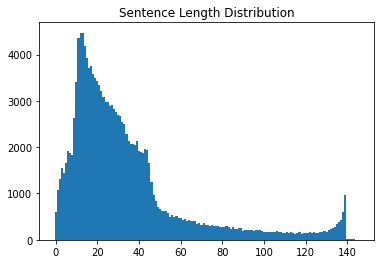

In [15]:
min_len = 999
max_len = 0
sum_len = 0

for i, sen in enumerate(train_data['document']):
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

Data Size: 146182
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


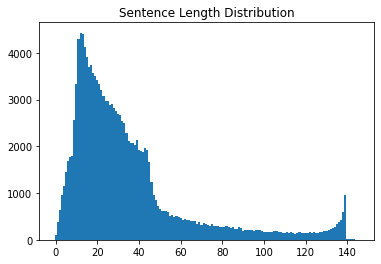

In [18]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(train_data['document']))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

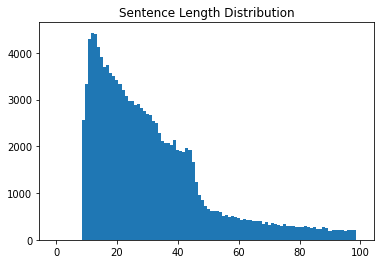

In [19]:
max_len = 100
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [20]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer